# theWhyKingz

# data

user - уникальный идентификатор пользователя;

session - уникальный идентификатор игровой сессии;

start - начало сессии;

finish - соответсвенно, ее завершение;

score - сумма набранных за сессию очков. Согласно игровому процессу, очки начисляются за успешные действия игроком, и следовательно, снимаются за неуспешные. 
	Положительный результат записывается пользователю на баланс и позволяет продолжить игру. Отрицательный - вынуждает пользователя ждать, либо платить, чтобы продолжать.
    
rounds - число действий, за которые начислялись либо снимались очки.



# tasks

1. Какая в среднем длина жизни пользователя в игре;

2. Сколько пользователей можно ожидать в течение первого полугодия 2020 года. Отобразите в динамике по месяцам;

3. Какими свойствами обладает группа пользователей, чей показатель длины жизни ниже среднего;

4. Соответственно, какими свойствами обладает группа, чья длина жизни выше среднего;

Также, спрогнозируйте вероятность потери пользователя по итогам его сессии.


# take into account

Держите, пожалуйста, во внимании:

 - данные преднамерено содержат ошибки;
 
 - статистика отображает лишь один год из жизни гипотетической игры;
 
 - оцениваться будут не только ответы, но и способы их получения, поэтому постарайтесь предоставить понятное и развернутое решение.

In [4]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import integrate
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path
import sys

PATH = '/Users/danil/Documents/github/theWhyKingz'
sys.path.append(str(PATH))

from src.whykingz import approximate_function, compare_groups

открываем данные

In [5]:
df = pd.read_csv(PATH + '/data/gamestat.csv')

print(df.shape)
df.head()

(361116, 6)


,user,session,start,finish,score,rounds
0,53d9318ceefe445c388b543f,5c2aad8f30cedb58bd7616b8,2019-01-01 00:00:15,2019-01-01 00:02:31,1069,19
1,53d9318ceefe445c388b543f,5c2aae2f30cedb5340379c37,2019-01-01 00:02:55,2019-01-01 00:20:17,1093,115
2,589700aaa5caf66c0c8b456b,5c2aae3f30cedb45d63d3378,2019-01-01 00:03:11,2019-01-01 00:10:12,119,21
3,58722fb09b5e361b4f8b4569,5c2aaef430cedb3a1756bb6c,2019-01-01 00:06:12,2019-01-01 00:08:13,102,17
4,597ac4e59b5e36e8758b457d,5c2aaf1a30cedb45843a43e7,2019-01-01 00:06:50,2019-01-01 00:12:04,-287,30


для удобства я бы заменил user и session на порядковые номера

In [6]:
df['user_id'] = df['user'].astype('category').cat.codes
df['session_id'] = df.groupby(['user_id'])['session'].cumcount() + 1

df['start'] = pd.to_datetime(df['start'])
df['finish'] = pd.to_datetime(df['finish'])

df['start_doy'] = df['start'].dt.dayofyear
df['finish_doy'] = df['finish'].dt.dayofyear

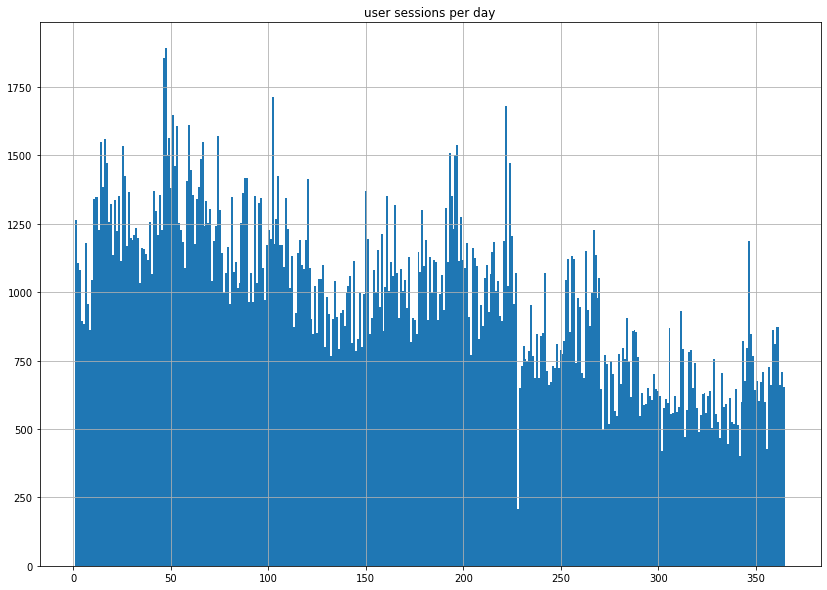

In [7]:
df['start_doy'].hist(bins = 365, figsize=(14, 10)).set_title('user sessions per day');

как видим со временем количество сессий становиться все меньше

# taks 1. Какая в среднем длина жизни пользователя в игре

сначала посмотрим на то, сколько пользователей остаются на продукте в каком месяце

In [8]:
lifetime_df = df.groupby('user_id').aggregate({'start_doy': ['min'],'finish_doy': ['max'] })

lifetime_df.columns = ['_'.join(c[::-1]) for c in lifetime_df.columns]

lifetime_df['lifetime'] = lifetime_df.eval('max_finish_doy - min_start_doy')

мы разбиваем на 12 бинов (грубо говоря эта гистограма показывает на каком месяце какое количество пользователей отвалиться)

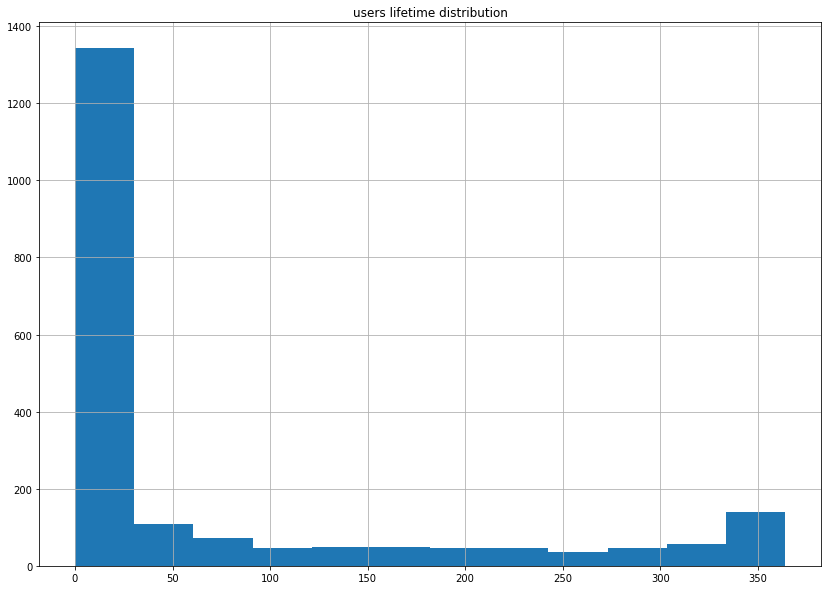

In [9]:
lifetime_df['lifetime'].hist(bins = 12, figsize=(14, 10)).set_title('users lifetime distribution');

как видим очень много пользователей отваливаются в первый месяц, но последняя колонка показывает что у нас есть лояльные пользователи 

для нахождения lifetime мне понравился подход с этой страницы

https://edu.devtodev.com/articles/212/glavnie-metriki-lifetime?lang=ru

где Lifetime - это, по сути, площадь под кривой Retention

а для этого нужно построить функцию которая будет аппроксимировать retention

берем значения retention (по дням)

In [10]:
retention = lifetime_df['lifetime'].value_counts().sort_index()

In [11]:
retention.head()

0    825
1    119
2     44
3     41
4     32
Name: lifetime, dtype: int64

In [12]:
retention.tail()

360    11
361     5
362     9
363    17
364    15
Name: lifetime, dtype: int64

In [13]:
retention_df = pd.DataFrame(retention).reset_index()
retention_df = retention_df.rename(columns={'index':'day', 'lifetime':'returned_users'})

number_of_users = lifetime_df.shape[0]
retention_df['retention'] = retention_df['returned_users']/number_of_users*100 # чтобы показать retention в %

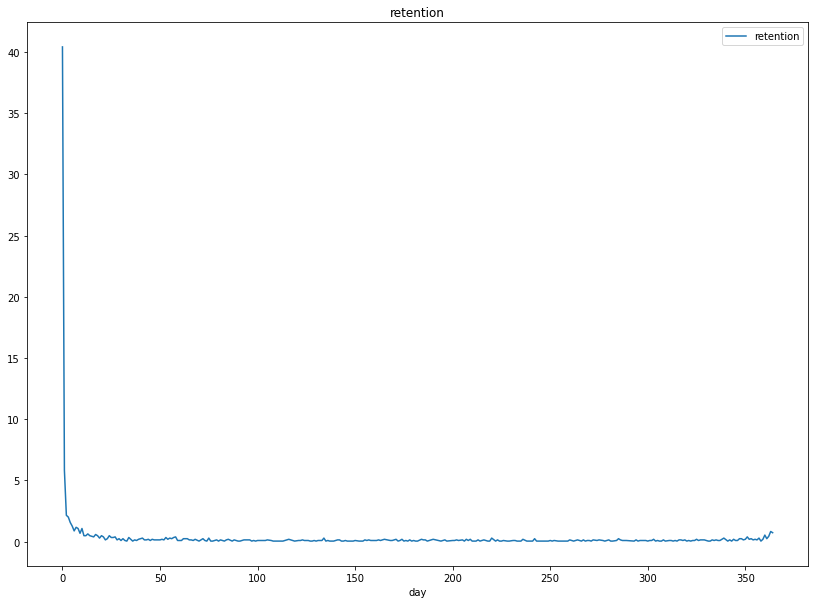

In [14]:
retention_df[['day', 'retention']].plot(x = 'day', y ='retention', figsize=(14, 10)).set_title('retention');


теперь находим аппроксимационную функцию

A=0.024751876660425876
h=0.15328467303356913


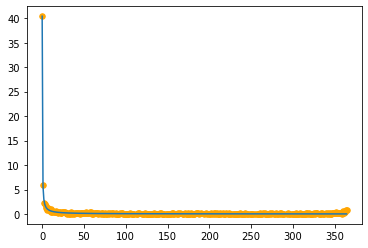

In [15]:
t = retention_df['day']
y = retention_df['retention']

popt, pcov = curve_fit(approximate_function, t, y)    

print('A={0}\nh={1}'.format(*tuple(popt)))

plt.scatter(t, y, s=30, color='orange')
plt.plot(t, approximate_function(t, *popt));

In [21]:
retention_df['prediction'] = retention_df['day'].apply(lambda x: approximate_function(x, *popt))

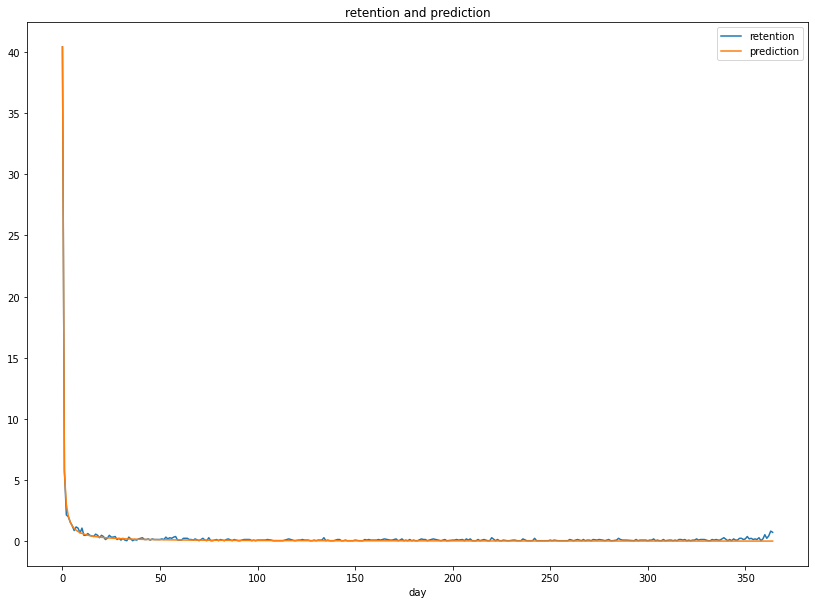

In [23]:
retention_df[['day', 'prediction', 'retention']].plot(x = 'day', y =['retention', 'prediction'], 
                                                      figsize=(14, 10)).set_title('retention and prediction');

теперь считаем площадь под кривой

In [24]:
A, h = popt

retention_approximation = lambda x: 1/(h*x +A)
LT, error = integrate.quad(retention_approximation, 0, 365)
LT

50.38817641845061

# task 2. Сколько пользователей можно ожидать в течение первого полугодия 2020 года. Отобразите в динамике по месяцам;

тк это веб трафик, уместно использовать библиотека от facebook - fbprophet, тк она хорошо работает с временными рядами веб трафика

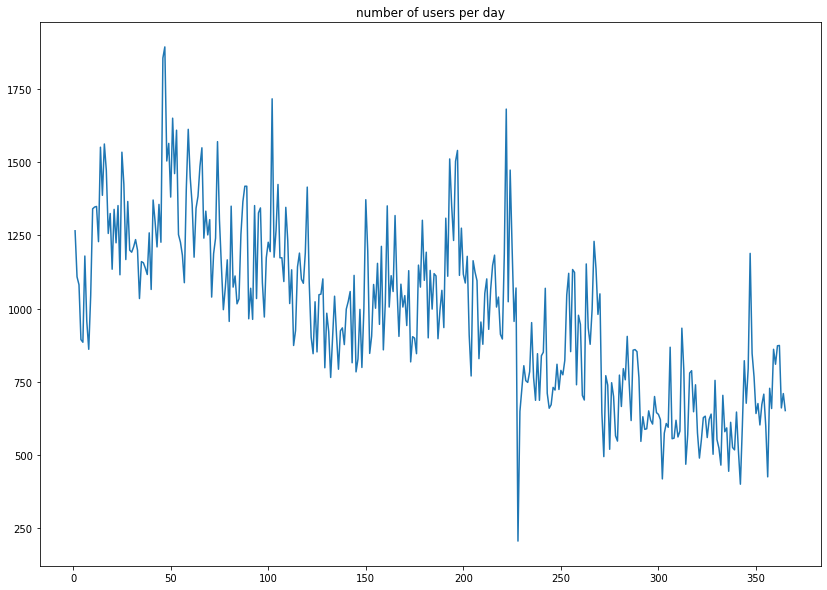

In [26]:
df['start_doy'].value_counts().sort_index().plot(figsize = (14, 10)).set_title('number of users per day');

In [35]:
prediction_s = df['start_doy'].value_counts().sort_index()

prediction_df = df[['start', 'user_id']].copy()
prediction_df['date'] = df['start'].dt.date
prediction_df = prediction_df[['user_id', 'date']].drop_duplicates()

In [36]:
print(prediction_df.shape)
prediction_df.head()

(30936, 2)


,user_id,date
0,10,2019-01-01
2,123,2019-01-01
3,64,2019-01-01
4,388,2019-01-01
6,868,2019-01-01


проверяем что никакой день не потерян

In [30]:
len(prediction_df['date'].unique())

365

создаем датафрейм в котором будет дата и количество пользователей. Переименовуем колонки, чтобы потом это все в prophet использовать

In [37]:
prediction_df = prediction_df.groupby('date').count().reset_index().rename(columns={'date': 'ds', 'user_id': 'y'})

разделяем на train и test

In [38]:
TRAIN_RATIO = 0.7

train_period = round(len(prediction_s) * TRAIN_RATIO)
print('количество дней на которых будем обучаться:', train_period)
predict_period = len(prediction_df['ds'].unique()) - train_period
print('количество дней на которых будем оценивать:', predict_period,)
df_train = prediction_df[:train_period]
df_test = prediction_df[train_period:]

количество дней на которых будем обучаться: 255
количество дней на которых будем оценивать: 110


обучаем модель и делаем предсказания

In [39]:
m = Prophet(seasonality_mode='additive',weekly_seasonality=True,
            daily_seasonality=False  )
m.fit(df_train)
# predict
future = m.make_future_dataframe(periods=predict_period)
forecast = m.predict(future)
# get forecast
raw_data_forecast = forecast['yhat'][-predict_period:]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


смотрим на ошибочки

In [40]:
print('MAE:', mean_absolute_error(raw_data_forecast.values, df_test['y'].values))
print('MSE:', mean_squared_error(raw_data_forecast.values, df_test['y'].values))

MAE: 6.952199812803115
MSE: 75.71664334631778


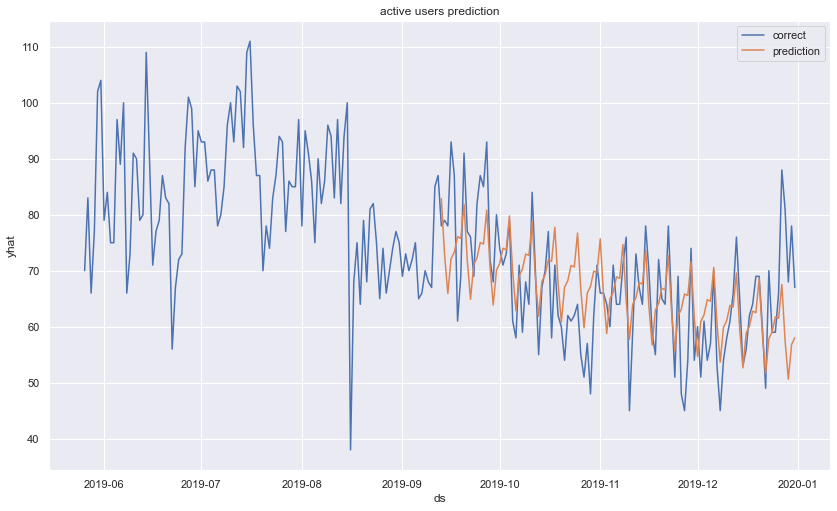

In [42]:
sns.set(rc={'figure.figsize':(14,8.27)})

ax = sns.lineplot(x="ds", y="y", data=prediction_df[-2* predict_period:], label='correct')
ax = sns.lineplot(x="ds", y="yhat", data=forecast[['ds', 'yhat']][-predict_period:], label='prediction')
ax.set_title('active users prediction');

работает довольно неплохо, я пытался подобрать другие параметры, например yearly_seasonality, n_changepoints, но они прироста не дали по метрикам

In [43]:
PREDICT_PERIOD = 182
m = Prophet(seasonality_mode='additive',weekly_seasonality=True,
            daily_seasonality=False  )
m.fit(prediction_df)
future = m.make_future_dataframe(periods=PREDICT_PERIOD)
forecast = m.predict(future)
# get forecast
raw_data_forecast = forecast['yhat'][-predict_period:]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


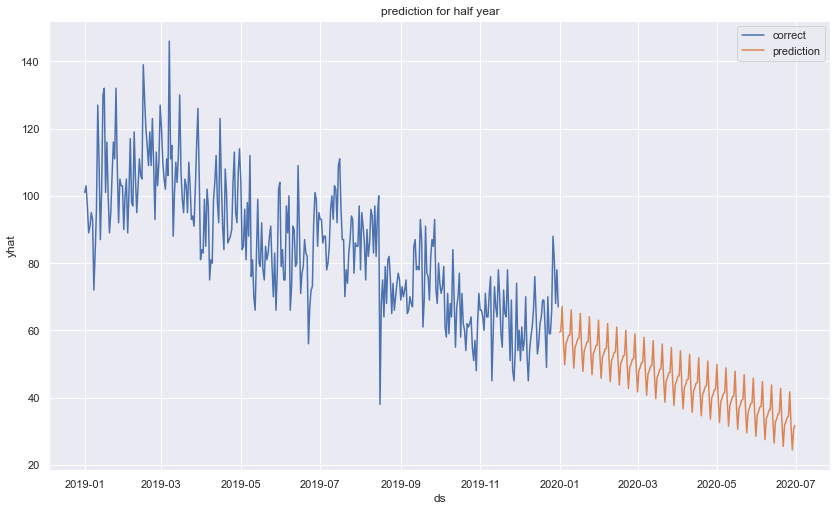

In [46]:
ax = sns.lineplot(x="ds", y="y", data=prediction_df, label='correct')
ax = sns.lineplot(x="ds", y="yhat", data=forecast[['ds', 'yhat']][-PREDICT_PERIOD:], label='prediction')
ax.set_title('prediction for half year');

как для меня, то выглядит не очень, этот метод на большем обьеме данных должен лучше себя показать, тк это веб трафик, с ним prophet хорошо работает, можете в моей статье посмотреть 
https://medium.com/genesis-media/time-series-forecasting-number-of-sessions-on-web-site-c36c85ebdbc

переходим к предсказаниям в размере по месяцам

In [47]:
prediction_df['month'] = pd.to_datetime(prediction_df['ds']).values.astype('datetime64[M]')
users_by_month = prediction_df.groupby('month')['y'].sum()

forecast = forecast[['ds', 'yhat']][-PREDICT_PERIOD:]
forecast['month'] = pd.to_datetime(forecast['ds']).values.astype('datetime64[M]')
prediction_users_by_month = forecast.groupby('month')['yhat'].sum()

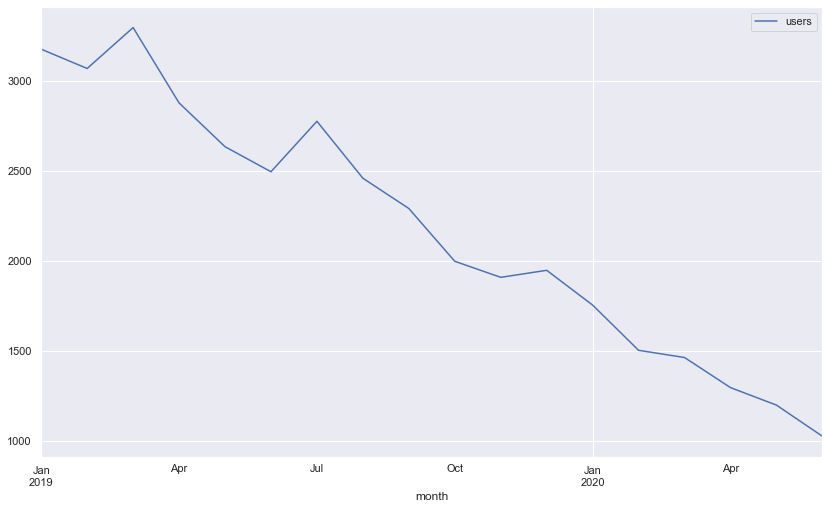

In [48]:
prediction_result = users_by_month.append(prediction_users_by_month).reset_index().rename(columns={0:'users'})
prediction_result['users'] = prediction_result['users'].astype(int)
prediction_result.plot(x = 'month', y ='users');

In [49]:
prediction_result[-6:]

,month,users
12,2020-01-01,1756
13,2020-02-01,1505
14,2020-03-01,1465
15,2020-04-01,1298
16,2020-05-01,1201
17,2020-06-01,1028


# task 3, 4 

Какими свойствами обладает группа пользователей, чей показатель длины жизни ниже среднего;

Соответственно, какими свойствами обладает группа, чья длина жизни выше среднего;

я бы обьеденил 2 этих вопроса, чтобы показать различие этих групп 

делаем дополнительные фичи по которым будем характеризовать эти группы

session_len - длинна сессии в секундах

weekday - день недели

mean_round_len - средняя длинна раунда у пользователя

mean_round_income - средний доход от раунда у пользователя

lifetime - сколько дней с напи пользователь (от самого первого до последней сессии)

loyal_user - 1-продолжительность жизни выше LT, 0 - ниже

frequency_per_day - средняя частота захода в день для пользователя

mean_scor_per_day - среднее заработанное количество очков в день для пользователя

In [50]:
df.head()

,user,session,start,finish,score,rounds,user_id,session_id,start_doy,finish_doy
0,53d9318ceefe445c388b543f,5c2aad8f30cedb58bd7616b8,2019-01-01 00:00:15,2019-01-01 00:02:31,1069,19,10,1,1,1
1,53d9318ceefe445c388b543f,5c2aae2f30cedb5340379c37,2019-01-01 00:02:55,2019-01-01 00:20:17,1093,115,10,2,1,1
2,589700aaa5caf66c0c8b456b,5c2aae3f30cedb45d63d3378,2019-01-01 00:03:11,2019-01-01 00:10:12,119,21,123,1,1,1
3,58722fb09b5e361b4f8b4569,5c2aaef430cedb3a1756bb6c,2019-01-01 00:06:12,2019-01-01 00:08:13,102,17,64,1,1,1
4,597ac4e59b5e36e8758b457d,5c2aaf1a30cedb45843a43e7,2019-01-01 00:06:50,2019-01-01 00:12:04,-287,30,388,1,1,1


In [52]:
df['session_len'] = (df['finish'] - df['start']).dt.seconds

df['weekday'] = df['start'].dt.weekday 

user_df = df.groupby('user_id').aggregate({'session_id': ['count'],
                                 'session_len': ['mean'], 
                                 'score': ['mean', 'min', 'max', 'sum'], 
                                 'rounds': ['mean'], 
                                           'start_doy' : ['min'],
                                           'finish_doy' : ['max']})

user_df.columns = ['_'.join(c[::-1]) for c in user_df.columns]

user_df['mean_round_len'] = user_df.eval('mean_session_len / mean_rounds')
user_df['mean_round_income'] = user_df.eval('mean_score / mean_rounds')

user_df['lifetime'] = user_df.eval('max_finish_doy - min_start_doy + 1') 
# + 1 тк в день когда он зашел он уже 1 день поиграл
user_df['loyal_user'] = np.where(user_df['lifetime'] >= LT, 1, 0)

user_df['frequency_per_day'] = user_df.eval('count_session_id / lifetime')
user_df['mean_scor_per_day'] = user_df.eval('sum_score / lifetime')

In [53]:
user_df.head()

,count_session_id,mean_session_len,mean_score,min_score,max_score,sum_score,mean_rounds,min_start_doy,max_finish_doy,mean_round_len,mean_round_income,lifetime,loyal_user,frequency_per_day,mean_scor_per_day
user_id,,,,,,,,,,,,,,,
0,23,240.000000,251.173913,-15,771,5777,30.695652,235,251,7.818697,8.182720,17,0,1.352941,339.823529
1,244,282.610656,1383.700820,-41832,23165,337623,65.016393,1,236,4.346760,21.282337,236,1,1.033898,1430.605932
2,220,589.868182,19.468182,-7070,2388,4283,115.459091,43,338,5.108893,0.168615,296,1,0.743243,14.469595
3,23,3061.869565,-405.173913,-1574,0,-9319,603.956522,135,143,5.069685,-0.670866,9,0,2.555556,-1035.444444
4,79,7287.354430,-404.354430,-10711,21213,-31944,59.253165,7,362,122.986755,-6.824183,356,1,0.221910,-89.730337


смотрим весь список фичей

In [54]:
user_df.columns

Index(['count_session_id', 'mean_session_len', 'mean_score', 'min_score',
       'max_score', 'sum_score', 'mean_rounds', 'min_start_doy',
       'max_finish_doy', 'mean_round_len', 'mean_round_income', 'lifetime',
       'loyal_user', 'frequency_per_day', 'mean_scor_per_day'],
      dtype='object')

исключаем не информативные фичи с этого списка

In [55]:
features = [x for x in (user_df.columns) if x not in ['min_start_doy', 'max_finish_doy', 'lifetime', 'loyal_user']]
features

['count_session_id',
 'mean_session_len',
 'mean_score',
 'min_score',
 'max_score',
 'sum_score',
 'mean_rounds',
 'mean_round_len',
 'mean_round_income',
 'frequency_per_day',
 'mean_scor_per_day']

по одной фиче я буду выводить график и оставлять комментарии

loyal - распределение фичи для пользователей, которые пользуются платформой дольше чем LT

unloyal - распределение фичи для пользователей, которые пользуются платформой меньше чем LT

-------------------- feature name: count_session_id --------------------
lower_bound: 1.0 
upper_bound: 792.1999999999971
confident interval for median in loyal group: (84, 128)
confident interval for median in unloyal group: (6, 7)


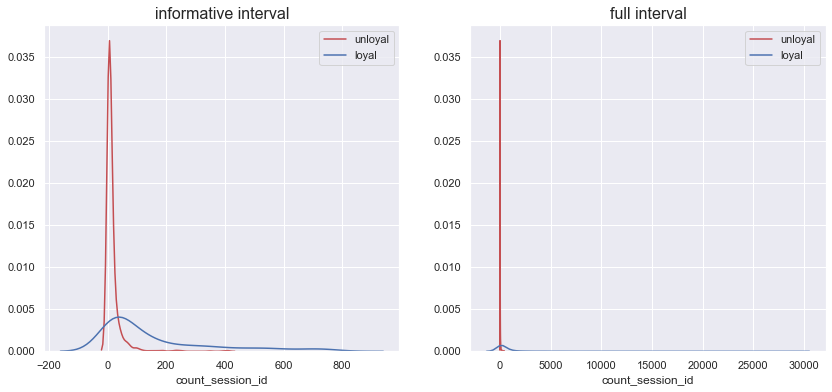

In [64]:
compare_groups(user_df, 'count_session_id')

по количеству сессий очень хорошо можно разделить лояльных пользователей от остальных, хотя это и так логично, но понятно что после 7 сессии половина не лояльных уже отваливается

-------------------- feature name: mean_session_len --------------------
lower_bound: 102.68333333333334 
upper_bound: 1518.7553629081942
confident interval for median in loyal group: (400.1003717472119, 461.2267884322679)
confident interval for median in unloyal group: (352.8, 389.0)


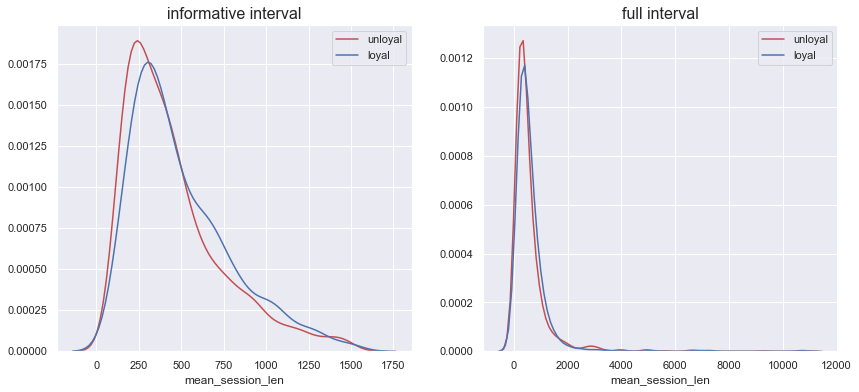

In [65]:
compare_groups(user_df, 'mean_session_len')

по средней длинне сессии тоже можно разделить, если пользоватлель за сессию в среднем проводит больше 389 секунд, то это скорее лояльный пользователь 

-------------------- feature name: mean_score --------------------
lower_bound: -1276.240476190476 
upper_bound: 1504.079999999999
confident interval for median in loyal group: (128.35250463821893, 195.75757575757575)
confident interval for median in unloyal group: (172.1818181818182, 213.91666666666666)


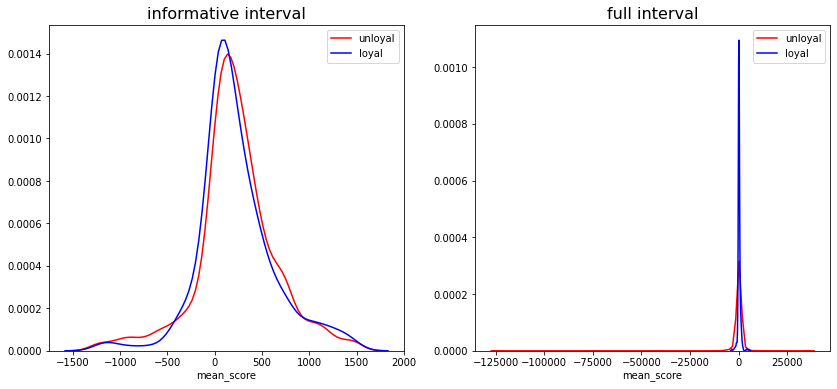

In [70]:
compare_groups(user_df, 'mean_score')

по среднему выиграшу за сессию врядли можно сдлеать вывод к какой группе принадлежит пользователь

-------------------- feature name: min_score --------------------
lower_bound: -76014.24999999999 
upper_bound: 660.9499999999998
confident interval for median in loyal group: (-13096, -9172)
confident interval for median in unloyal group: (-644, -389)


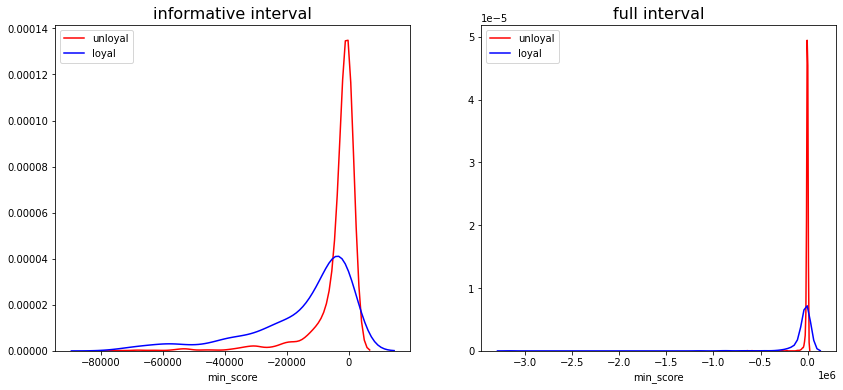

In [71]:
compare_groups(user_df, 'min_score')

по фиче - максимальный проигрыш видно что лояльные пользователи готовы больше проигрывать за одну сессию и это их не пугает, в то время как половина не лояльных не проигрывает больше 644 очков

-------------------- feature name: max_score --------------------
lower_bound: 70.20000000000005 
upper_bound: 30489.899999999892
confident interval for median in loyal group: (3786, 5133)
confident interval for median in unloyal group: (1050, 1232)


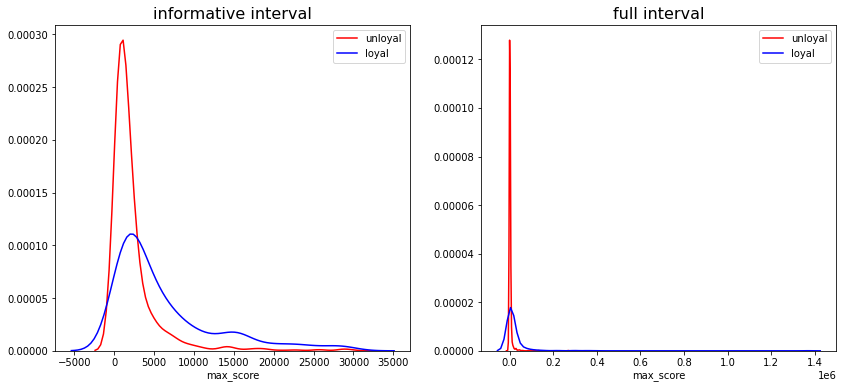

In [72]:
compare_groups(user_df, 'max_score')

а по максимальному выграшу видно, что лояльные могут за сессию выигрывать больше, что логично из за количества сессий

очень странно, что есть пользователи из лояльной группы, у которых максимум имеет отрицательное значение, возможно это и есть преднамерренно искаженные данные

-------------------- feature name: sum_score --------------------
lower_bound: -36260.85 
upper_bound: 150984.7499999995
confident interval for median in loyal group: (7306, 11772)
confident interval for median in unloyal group: (1091, 1374)


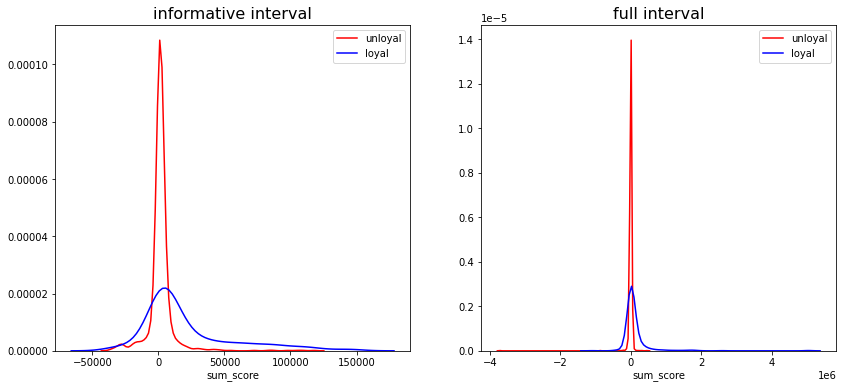

In [73]:
compare_groups(user_df, 'sum_score')

тут было бы интересно посмотреть, посмотреть 75 персентиль, чтобы понять после каких значений уже мало останеться нелояльных. но пока видно что те кто больше 11772 очков заработал в сумме, уже скорее лояльный пользователь

-------------------- feature name: mean_rounds --------------------
lower_bound: 12.0 
upper_bound: 264.87499999999955
confident interval for median in loyal group: (65.015625, 74.83333333333333)
confident interval for median in unloyal group: (56.42424242424242, 63.0)


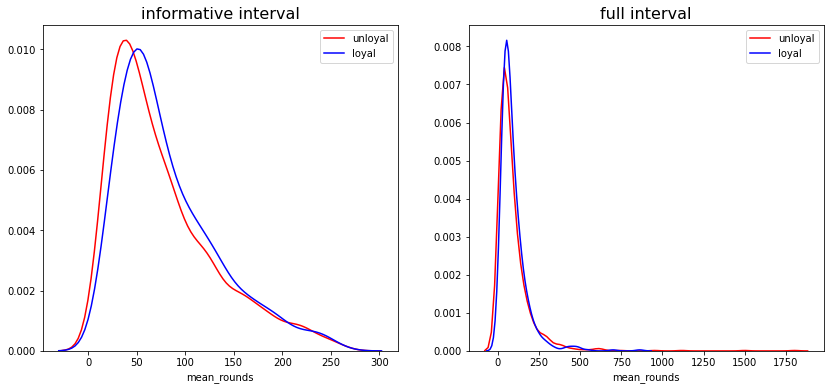

In [74]:
compare_groups(user_df, 'mean_rounds')

тут видно в лояльные пользователи обычно больше проводят раундов за сессию, тк видно что оверительные интервалы не пересекаются. 

-------------------- feature name: mean_round_len --------------------
lower_bound: 3.1310047340226737 
upper_bound: 25.025333333333332
confident interval for median in loyal group: (5.542446043165467, 5.8778631252602835)
confident interval for median in unloyal group: (5.527007299270073, 5.8)


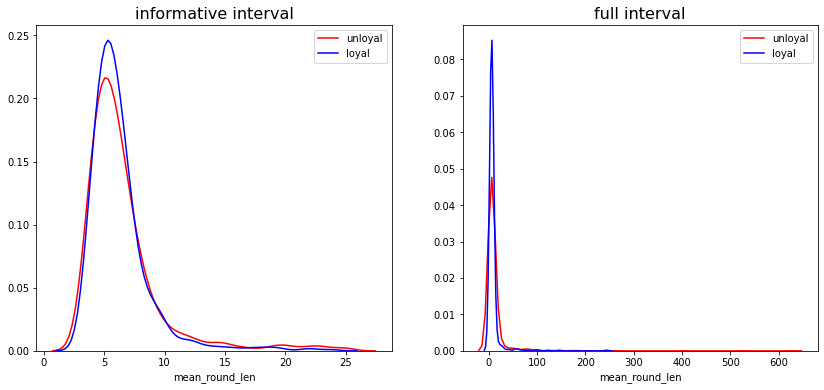

In [75]:
compare_groups(user_df, 'mean_round_len')

обычно пользователи обоих групп проводят одинаковое время на каждом раунде и тут не получается сделать выводы

-------------------- feature name: mean_round_income --------------------
lower_bound: -13.877207700711127 
upper_bound: 32.460536477523924
confident interval for median in loyal group: (1.7319306997076729, 2.362801377726751)
confident interval for median in unloyal group: (2.927927927927928, 3.6706500956022943)


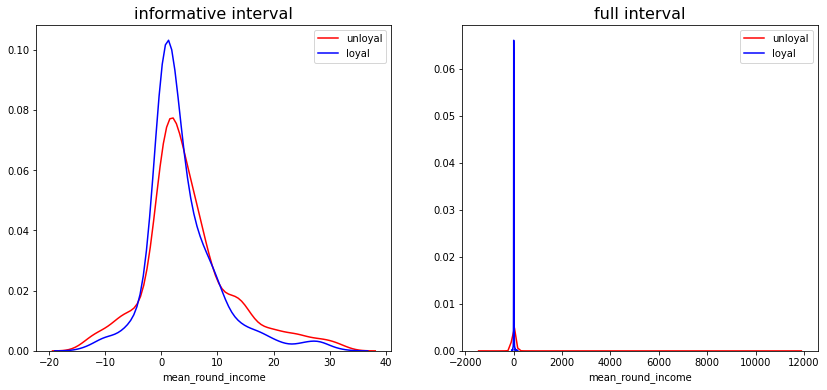

In [76]:
compare_groups(user_df, 'mean_round_income')

что интересно, обычно за раунд не лояльные пользователи, выигрывают за раунд больше, чем лояльные. 

-------------------- feature name: frequency_per_day --------------------
lower_bound: 0.10856952519379846 
upper_bound: 15.0
confident interval for median in loyal group: (0.5172413793103449, 0.6886792452830188)
confident interval for median in unloyal group: (3.0, 4.0)


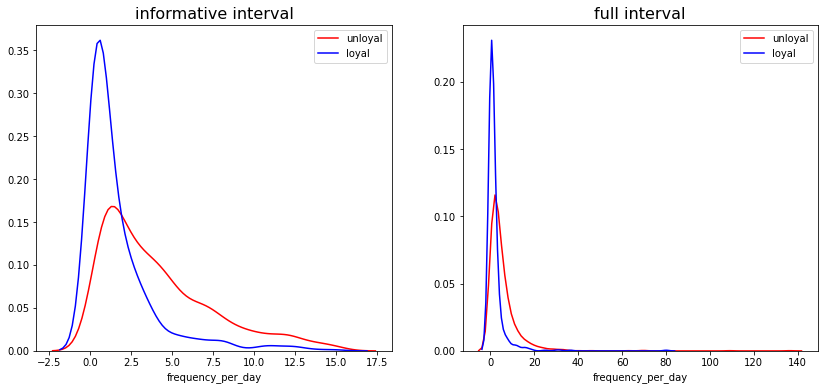

In [77]:
compare_groups(user_df, 'frequency_per_day')

по эти графикам видно что чем выше частота заходов в день, тем скорее пользователь относиться не к лояльной группе, но думаю эту метрику стоит пересчитать только на дни когда пользователь непосредственно заходил на платформу

-------------------- feature name: mean_scor_per_day --------------------
lower_bound: -4782.599999999998 
upper_bound: 4152.499999999998
confident interval for median in loyal group: (46.56043956043956, 70.325)
confident interval for median in unloyal group: (534.0, 677.5)


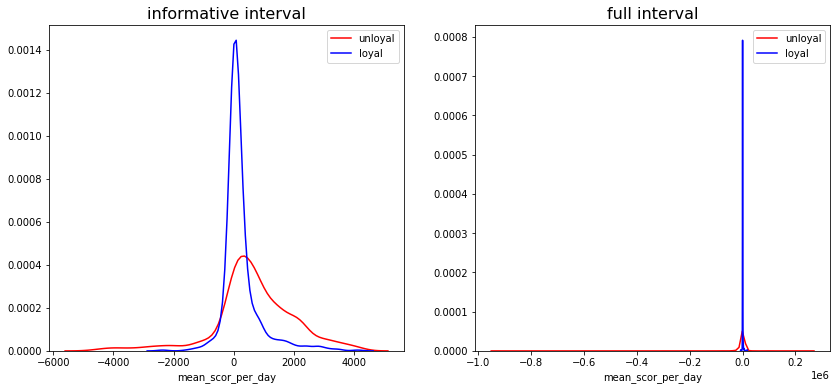

In [78]:
compare_groups(user_df, 'mean_scor_per_day')

точно такой же вывод что и для предыдущей метрики

Анализ предпочтительных часов и дней недели

In [67]:
df['weekday'] = df['start'].dt.weekday
df['hour'] = df['start'].dt.hour

In [70]:
pref_time_df = pd.merge(df[['user_id', 'weekday', 'hour']], user_df.reset_index()[['user_id', 'loyal_user']], 
                        on='user_id')

unloyal_users = user_df[user_df['loyal_user'] == 0].shape[0]
loyal_users = pref_time_df[pref_time_df['loyal_user'] == 0].shape[0]

In [71]:
unloyal_user_session_num = pref_time_df[pref_time_df['loyal_user'] == 0].shape[0]
loyal_user_session_num = pref_time_df[pref_time_df['loyal_user'] == 1].shape[0]

посещения по дням недели

In [72]:
unloyay_days = pref_time_df[pref_time_df['loyal_user'] == 0]['weekday'].value_counts().sort_index()/unloyal_user_session_num
loyal_days = pref_time_df[pref_time_df['loyal_user'] == 1]['weekday'].value_counts().sort_index()/loyal_user_session_num


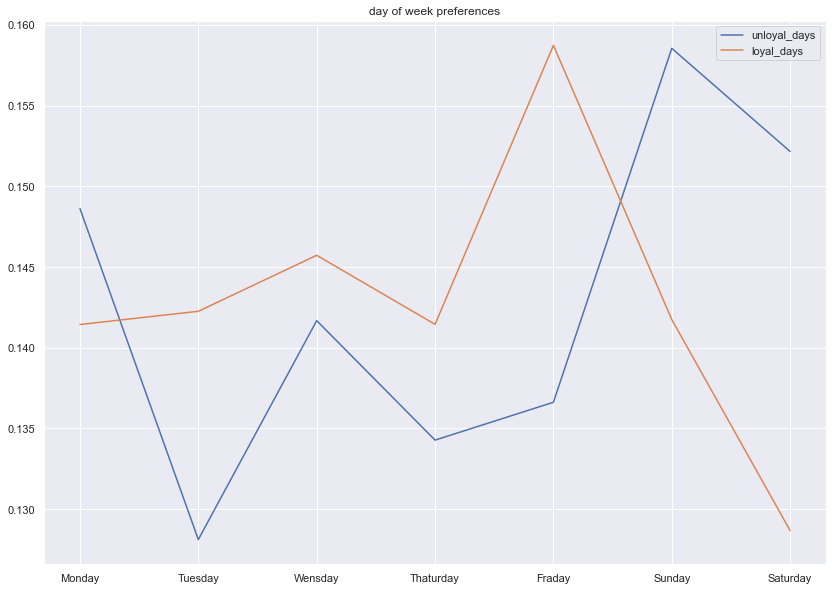

In [78]:
days_df = pd.DataFrame([unloyay_days, loyal_days]).T
days_df.columns = ['unloyal_days', 'loyal_days']

days = pd.Series(['Monday', 'Tuesday', 'Wensday', 'Thaturday', 'Fraday', 'Sunday', 'Saturday'])
ax = days_df.plot(figsize = (14,10), grid = True);
ax.set_xticks(range(len(days)))
ax.set_xticklabels(days);
ax.set_title('day of week preferences');

как мы тут видим то лояльные пользователи чаще сидят в выходные дни и понедельник (возможно еще ночью досижывают или время на разных географиях сохраняется не в соответствие с часовым поясом), а не лояльные очень часто заходят в пятницу

In [76]:
unloyal_hours = pref_time_df[pref_time_df['loyal_user'] == 0]['hour'].value_counts().sort_index()/unloyal_user_session_num
loyal_hours = pref_time_df[pref_time_df['loyal_user'] == 1]['hour'].value_counts().sort_index()/loyal_user_session_num


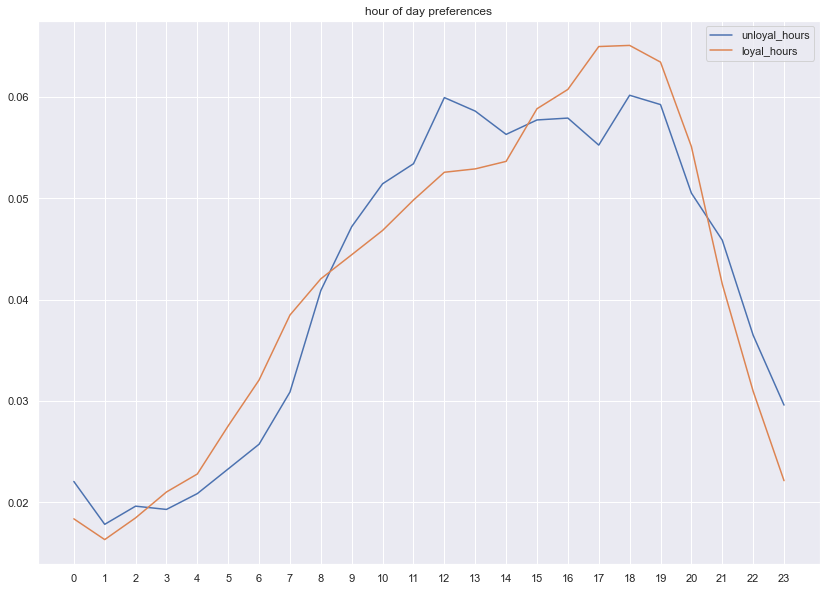

In [77]:
hours_df = pd.DataFrame([unloyal_hours, loyal_hours]).T
hours_df.columns = ['unloyal_hours', 'loyal_hours']

ax = hours_df.plot(figsize = (14,10), grid = True);
ax.set_xticks(range(len(hours_df)));
ax.set_title('hour of day preferences');

как видим пик посещений не лояльных пользователей приходится на 17-19 часов, и можно выделить плато для лояльных пользователей с 12 до 19, в эти часы они чаще всего заходят. ну и что я ожидал, лояльные игроки любят сидеть вечером с 21 до 2 часов ночи их доля больше, чем не лояльных.

# следующие этапы

1) для сравнения добавить такие фичи как
- среднее количество сессий в день когда пользователь пользовался платформой
- количество сессий в течении перых N (3 например я бы брал )дней и за первую неделю
- сумма заработанных очков в течении перых N (3 например я бы брал ) дней и за первую неделю
- сумма заработанных очков в течении перых N (3 например я бы брал ) дней и за первую неделю
- средняя пауза между сессиями (найти значение которым можно разделить, что пользователь полностью вышел из платформы, а не вернулся сразу, и вот на уровне таких заходов найти средний промежуток времени когда он заходит снова)

2) для временных рядов можно попробовать другие мдели и создать сравнительную таблицу по подходам, значениями метрики которые они показывают, времени обучения. обучаться на ряде агрегированных данных (например не по сумме пользователей в день, а на количестве пользователей за неделю, месяц, но это только если данных есть на несколько лет)

3) прогнозировать пользователей по итогам сессии я бы попробовал при помощи NLP подходов, там же есть предсказание следующего слова. А в нашей задаче вместо слова взять действие, которое бы описывалось количеством раундов и выигранных очков. Честно, с таким не работал, так что говорю на уровне гипотезы.
Или вместо NLP подходов искользовать цепи Маркова.